In [ ]:
# Data:
# https://github.com/markzhdan/hltv-top-20-predictions/tree/main/data/clean/complex/final

# Video:
# https://youtu.be/6DBWzcojKW4

In [122]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
years = range(2018, 2024)
dfs = []

base_path = '../../data/clean/complex/final/player_data_{}.csv'
for year in years:
    df = pd.read_csv(base_path.format(year))
    df['Year'] = year
    df['Score'] = 101 - df['Rank']  # convert rank to score
    dfs.append(df)

train_df = pd.concat(dfs, ignore_index=True)

train_df.head()


,Player,adr,assists__per__round,b_adr,b_assists__per__round,b_damage__per__round,b_deaths__per__round,b_dpr,b_grenade_dmg__per__round,b_headshot_%,...,vs_top20,vs_top30,vs_top5,MVPs,EVPs,Rank,Year,Score,b_rating_1.0,m_rating_1.0
0,s1mple,87.2,0.10,87.4,0.11,87.4,0.59,0.59,2.7,41.7,...,1.34,1.34,1.35,6,4,1,2018,100,NaN,NaN
1,device,81.4,0.12,80.8,0.12,80.8,0.59,0.59,5.1,32.3,...,1.24,1.24,1.23,7,1,2,2018,99,NaN,NaN
2,NiKo,84.8,0.13,86.6,0.13,86.6,0.63,0.63,3.6,48.3,...,1.20,1.21,1.21,2,7,3,2018,98,NaN,NaN
3,electronic,84.5,0.14,82.2,0.13,82.2,0.63,0.63,4.6,48.7,...,1.16,1.18,1.20,0,7,4,2018,97,NaN,NaN
4,dupreeh,79.8,0.14,78.7,0.14,78.7,0.63,0.63,3.2,49.7,...,1.17,1.16,1.17,1,8,5,2018,96,NaN,NaN


In [124]:
# Load 2024 test data
test_df = pd.read_csv('../../data/clean/complex/final/player_data_2024.csv')
test_df['Year'] = 2024
test_df['Score'] = 0  # Placeholder
test_df.head()


,Player,adr,assists__per__round,b_adr,b_assists__per__round,b_damage__per__round,b_deaths__per__round,b_dpr,b_grenade_dmg__per__round,b_headshot_%,...,total_kills,vs_top10,vs_top20,vs_top30,vs_top5,MVPs,EVPs,Rank,Year,Score
0,donk,96.8,0.21,94.3,0.20,94.3,0.68,0.68,3.3,58.4,...,3032.0,1.28,1.32,1.34,1.36,5,3,1,2024,0
1,m0NESY,82.7,0.14,82.8,0.14,82.8,0.59,0.59,3.0,42.1,...,3174.0,1.25,1.28,1.28,1.27,3,5,2,2024,0
2,ZywOo,88.9,0.18,87.6,0.17,87.6,0.59,0.59,4.1,44.0,...,2753.0,1.28,1.33,1.35,1.34,2,7,3,2024,0
3,NiKo,82.3,0.21,81.4,0.21,81.4,0.64,0.64,6.0,54.9,...,2927.0,1.16,1.17,1.17,1.16,0,6,4,2024,0
4,jL,78.5,0.21,78.3,0.20,78.3,0.65,0.65,4.6,54.7,...,2617.0,1.10,1.10,1.12,1.13,2,4,5,2024,0


In [125]:
# Handle different rating column versions
def unify_rating_columns(df):
    # Priority: use rating_2.1 if available, else rating_2.0
    if 'rating_2.1' in df.columns:
        df['rating'] = df['rating_2.1']
    elif 'rating_2.0' in df.columns:
        df['rating'] = df['rating_2.0']
    elif 'rating_1.0' in df.columns:
        df['rating'] = df['rating_1.0']
    else:
        df['rating'] = np.nan  # fallback

    # Drop older versions if present
    for col in ['rating_2.1', 'rating_2.0', 'rating_1.0']:
        if col in df.columns:
            df.drop(columns=col, inplace=True)

    return df

# Apply to both training and test sets
train_df = unify_rating_columns(train_df)
test_df = unify_rating_columns(test_df)


In [126]:
# Preprocess
id_cols = ['Player', 'HLTV_ID', 'Rank', 'Year']
feature_cols = [col for col in train_df.columns if col not in id_cols + ['Score']]
shared_cols = list(set(feature_cols) & set(test_df.columns))

train_df[shared_cols] = train_df[shared_cols].replace(-1.0, np.nan)
train_df[shared_cols] = train_df[shared_cols].fillna(train_df[shared_cols].mean())

test_df[shared_cols] = test_df[shared_cols].replace(-1.0, np.nan)
test_df[shared_cols] = test_df[shared_cols].fillna(train_df[shared_cols].mean())

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[shared_cols])
X_test = scaler.transform(test_df[shared_cols])
y_train = train_df['Score'].values


In [127]:
class DeepRankNet(nn.Module):
    def __init__(self, input_dim):
        super(DeepRankNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


Training Loop

In [128]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

model = DeepRankNet(input_dim=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train loop
for epoch in range(1000):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss / len(train_loader):.4f}")


Epoch 0: Loss = 7832.5253
Epoch 10: Loss = 235.9560
Epoch 20: Loss = 144.3420
Epoch 30: Loss = 115.8687
Epoch 40: Loss = 107.2165
Epoch 50: Loss = 97.3907
Epoch 60: Loss = 121.1475
Epoch 70: Loss = 119.6487
Epoch 80: Loss = 113.5207
Epoch 90: Loss = 94.5722
Epoch 100: Loss = 116.7171
Epoch 110: Loss = 86.5370
Epoch 120: Loss = 101.4132
Epoch 130: Loss = 91.8967
Epoch 140: Loss = 69.8568
Epoch 150: Loss = 94.2817
Epoch 160: Loss = 87.2544
Epoch 170: Loss = 89.0476
Epoch 180: Loss = 88.9893
Epoch 190: Loss = 77.1337
Epoch 200: Loss = 72.0740
Epoch 210: Loss = 86.7423
Epoch 220: Loss = 63.0700
Epoch 230: Loss = 71.0468
Epoch 240: Loss = 70.2820
Epoch 250: Loss = 70.1546
Epoch 260: Loss = 67.6670
Epoch 270: Loss = 64.8990
Epoch 280: Loss = 63.5078
Epoch 290: Loss = 65.2402
Epoch 300: Loss = 60.0403
Epoch 310: Loss = 55.4501
Epoch 320: Loss = 55.6733
Epoch 330: Loss = 71.4050
Epoch 340: Loss = 62.4182
Epoch 350: Loss = 67.5074
Epoch 360: Loss = 53.9862
Epoch 370: Loss = 50.8892
Epoch 380: L

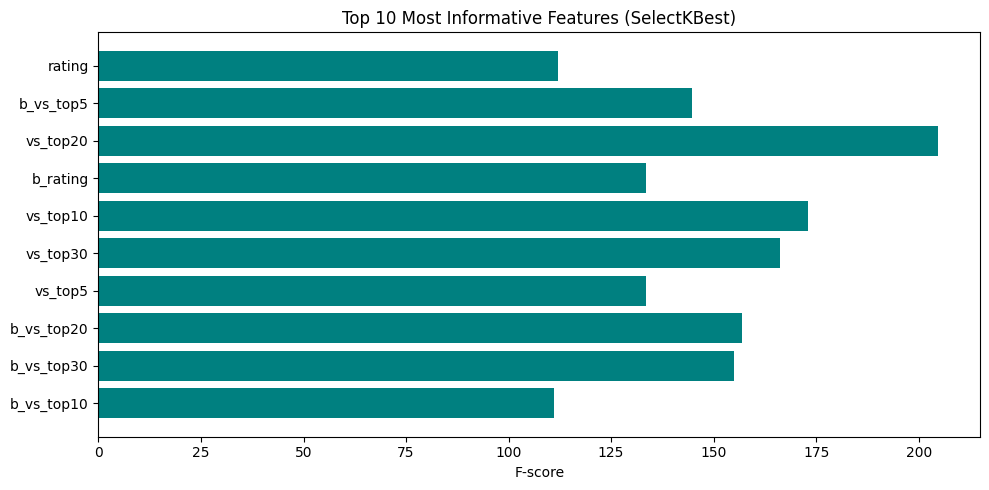

In [133]:
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt

# Ensure shared_cols and X_train are from earlier preprocessing steps
# shared_cols = list(set(feature_cols) & set(test_df.columns))

# Run feature selection again on training data
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X_train, y_train)

# Get top feature names and scores
top_k_indices = selector.get_support(indices=True)
top_k_features = [shared_cols[i] for i in top_k_indices]
top_k_scores = selector.scores_[top_k_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.barh(top_k_features, top_k_scores, color='teal')
plt.xlabel("F-score")
plt.title("Top 10 Most Informative Features (SelectKBest)")
plt.gca().invert_yaxis()  # Highest score at the top
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()


In [129]:
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    preds_2024 = model(X_test_tensor).numpy()

test_df['PredictedScore'] = preds_2024
top_20_2024 = test_df.sort_values(by='PredictedScore', ascending=False).head(20)
top_20_2024.reset_index(inplace=True)

print(top_20_2024[['Player', 'PredictedScore']])


       Player  PredictedScore
0        donk       99.943756
1      m0NESY       98.629677
2       ZywOo       98.241745
3        NiKo       94.521835
4       sh1ro       89.430038
5    XANTARES       87.797157
6      flameZ       87.572639
7          jL       87.001663
8       broky       86.169464
9     xertioN       85.643158
10      EliGE       84.988388
11  w0nderful       84.839157
12     frozen       84.793823
13    malbsMd       84.585800
14      Spinx       84.430130
15        b1t       83.323120
16      NertZ       82.757690
17       ropz       82.652237
18   KSCERATO       81.420609
19    Brollan       80.151138


In [ ]:
# Load actual HLTV 2024 rankings
actual_df = pd.read_csv('../../rankings/ranking_2024.csv')

# Normalize nicknames in both DataFrames (for easier comparison)
def normalize(name):
    return name.strip().lower().replace("⁠", "").replace("’", "'").replace("`", "'")

actual_df['Nickname'] = actual_df['Nickname'].apply(normalize)
top_20_2024['Player'] = top_20_2024['Player'].apply(normalize)

# Map: nickname -> actual rank
actual_ranks = {row['Nickname']: row['Rank'] for _, row in actual_df.iterrows()}

# Evaluation function
def score_ranking(pred_df, actual_rank_dict):
    score = 0
    graded = []

    for pred_rank, row in enumerate(pred_df['Player'].values, 1):
        actual_rank = actual_rank_dict.get(row)

        if actual_rank:
            diff = abs(actual_rank - pred_rank)
            if diff == 0:
                pts = 5
            elif diff == 1:
                pts = 4
            elif diff == 2:
                pts = 3
            elif diff == 3:
                pts = 2
            elif diff <= 5:
                pts = 1
            else:
                pts = 0
        else:
            pts = 0

        graded.append((pred_rank, row, actual_rank, pts))
        score += pts

    return score, graded


In [131]:
# Run scoring
total_score, breakdown = score_ranking(top_20_2024, actual_ranks)

# Display summary
print(f"🏆 Total Ranking Score: {total_score}/100\n")
print("🔍 Breakdown:")
for pred_rank, nickname, actual_rank, pts in breakdown:
    print(f"Predicted #{pred_rank:>2}: {nickname:<15} | Actual: {actual_rank if actual_rank else 'N/A':<2} | +{pts} pts")

🏆 Total Ranking Score: 58/100

🔍 Breakdown:
Predicted # 1: donk            | Actual: 1  | +5 pts
Predicted # 2: m0nesy          | Actual: 2  | +5 pts
Predicted # 3: zywoo           | Actual: 3  | +5 pts
Predicted # 4: niko            | Actual: 4  | +5 pts
Predicted # 5: sh1ro           | Actual: 6  | +4 pts
Predicted # 6: xantares        | Actual: 15 | +0 pts
Predicted # 7: flamez          | Actual: 7  | +5 pts
Predicted # 8: jl              | Actual: 5  | +2 pts
Predicted # 9: broky           | Actual: 8  | +4 pts
Predicted #10: xertion         | Actual: 14 | +1 pts
Predicted #11: elige           | Actual: 19 | +0 pts
Predicted #12: w0nderful       | Actual: 11 | +4 pts
Predicted #13: frozen          | Actual: 10 | +2 pts
Predicted #14: malbsmd         | Actual: 12 | +3 pts
Predicted #15: spinx           | Actual: 13 | +3 pts
Predicted #16: b1t             | Actual: 9  | +0 pts
Predicted #17: nertz           | Actual: 21 | +1 pts
Predicted #18: ropz            | Actual: 18 | +5 pts
Pr

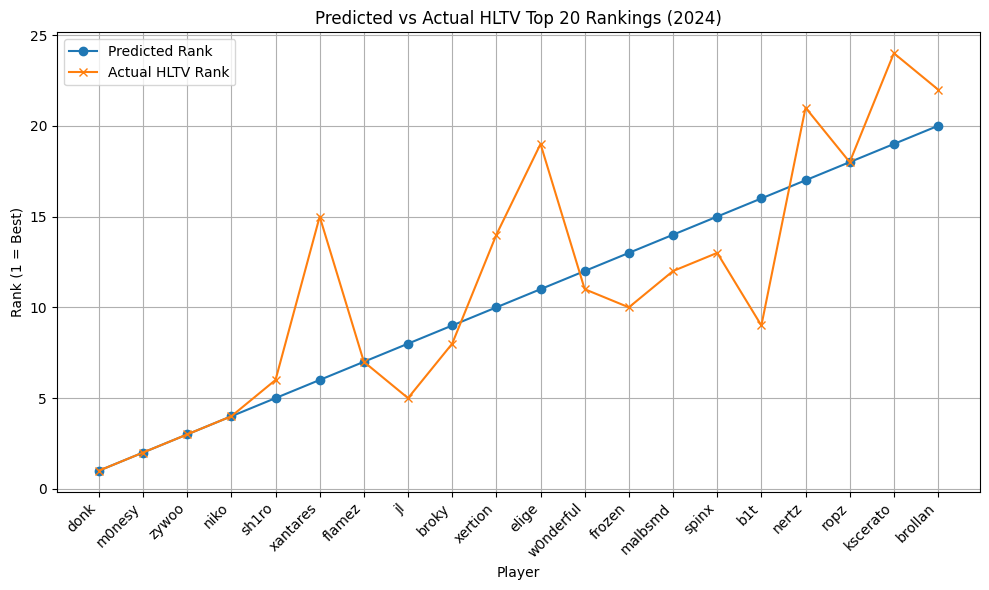

In [132]:
import matplotlib.pyplot as plt

# Normalize nicknames again for matching
def normalize(name):
    return name.strip().lower().replace("⁠", "").replace("’", "'").replace("`", "'")

actual_df['Nickname'] = actual_df['Nickname'].apply(normalize)
top_20_2024['Player'] = top_20_2024['Player'].apply(normalize)

# Create matching dict
actual_rank_map = {normalize(row['Nickname']): row['Rank'] for _, row in actual_df.iterrows()}

# Prepare bar chart
predicted_names = top_20_2024['Player'].tolist()
predicted_scores = list(range(1, 21))  # predicted rank = 1 to 20
actual_ranks = [actual_rank_map.get(name, None) for name in predicted_names]

plt.figure(figsize=(10,6))
plt.plot(predicted_names, predicted_scores, marker='o', label='Predicted Rank')
plt.plot(predicted_names, actual_ranks, marker='x', label='Actual HLTV Rank')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Player")
plt.ylabel("Rank (1 = Best)")
plt.title("Predicted vs Actual HLTV Top 20 Rankings (2024)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ranking_eval.png")
plt.show()
